#### Tasks:
* Build and submit a scikit-learn pipeline having neural network regressor as the model
* Build and submit a scikit-learn pipeline having gradient boosted regressor as the model
* Build and submit a xgboost model
* Achieve a score better than 0.13 on the public leaderboard

# Importing data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import skew 
from scipy.stats import norm
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler)
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import warnings
from sklearn import set_config
set_config(display='diagram')
warnings.filterwarnings("ignore")
!pip install xgboost

In [2]:
pd.set_option('display.max_columns', None)
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


* Each row in the dataset describes the characteristics of a house.
* Goal is to predict the SalePrice, given these features.
* Models are evaluated on the Root-Mean-Squared-Error (RMSE) between the log of the SalePrice predicted by the model, and the log of the actual SalePrice. Converting RMSE errors to a log scale ensures that errors in predicting expensive houses and cheap houses will affect the score equally.

In [3]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


Saving the 'Id' column:

In [4]:
train_ID = train_data['Id']
test_ID = test_data['Id']

Dropping the 'Id' column since it is unnecessary for  the prediction process:

In [5]:
train_data.drop("Id", axis = 1, inplace = True)
test_data.drop("Id", axis = 1, inplace = True)

# EDA

Checking for duplicate rows and columns

In [6]:
print('duplicated rows =',train_data.duplicated().sum())
print('columns containing missing values =', train_data.isnull().any().sum())

duplicated rows = 0
columns containing missing values = 19


### List of Numerical features

In [7]:
numerical_features = [feature for feature in train_data.columns if train_data[feature].dtypes != 'O']
print('Total numerical features : ', len(numerical_features))
train_data[numerical_features].head()

Total numerical features :  37


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


Missing numerical data:

In [8]:
train_data[numerical_features].isnull().sum().sort_values(ascending = False).head(3)

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
dtype: int64

### List of Temporal features

In [9]:
year_feature = [feature for feature in numerical_features if 'Yr' in feature or 'Year' in feature]
year_feature

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

Missing temporal data:

In [10]:
train_data[year_feature].isnull().sum().sort_values(ascending = False).head(1)

GarageYrBlt    81
dtype: int64

### List of variables that contain Discrete values

In [11]:
discrete_features=[feature for feature in numerical_features if train_data[feature].nunique()<25 and feature not in year_feature+['Id']]
print("Total discrete variables : ", len(discrete_features))
train_data[discrete_features].head()

Total discrete variables :  17


,MSSubClass,OverallQual,OverallCond,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,3SsnPorch,PoolArea,MiscVal,MoSold
0,60,7,5,0,1,0,2,1,3,1,8,0,2,0,0,0,2
1,20,6,8,0,0,1,2,0,3,1,6,1,2,0,0,0,5
2,60,7,5,0,1,0,2,1,3,1,6,1,2,0,0,0,9
3,70,7,5,0,1,0,1,0,3,1,7,1,3,0,0,0,2
4,60,8,5,0,1,0,2,1,4,1,9,1,3,0,0,0,12


Missing discrete data:

In [12]:
train_data[discrete_features].isnull().sum().sort_values(ascending = False).head(1)

MoSold    0
dtype: int64

### List of variables that contain continuous values

In [13]:
cont_features=[feature for feature in numerical_features if train_data[feature].nunique()>25 and feature not in year_feature+['Id']]
print("Total continuous variables : ", len(cont_features))
train_data[cont_features].head()

Total continuous variables :  16


,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SalePrice
0,65.0,8450,196.0,706,0,150,856,856,854,1710,548,0,61,0,0,208500
1,80.0,9600,0.0,978,0,284,1262,1262,0,1262,460,298,0,0,0,181500
2,68.0,11250,162.0,486,0,434,920,920,866,1786,608,0,42,0,0,223500
3,60.0,9550,0.0,216,0,540,756,961,756,1717,642,0,35,272,0,140000
4,84.0,14260,350.0,655,0,490,1145,1145,1053,2198,836,192,84,0,0,250000


Missing continuous data:

In [14]:
train_data[cont_features].isnull().sum().sort_values(ascending = False).head(2)

LotFrontage    259
MasVnrArea       8
dtype: int64

### List of Categorical features

In [15]:
catg_features = [feature for feature in train_data.columns if train_data[feature].dtypes == 'O']
print("Total categorical variables : ", len(cont_features))
train_data[catg_features].head()

Total categorical variables :  16


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


Missing categorical data:

In [16]:
train_data[catg_features].isnull().sum().sort_values(ascending = False).head(16)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtQual          37
BsmtCond          37
MasVnrType         8
Electrical         1
dtype: int64

'NaN' for cateogrical data represents 'No' (i.e. no garage) and is not an indicator of missing data.

In [17]:
train_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Total missing data

In [18]:
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (total /  train_data.shape[0]).sort_values(ascending = False)   
missing_data = pd.concat([total, percent], axis = 1, keys = ['total', 'percent'])
missing_data.head(19)

,total,percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


More than 80% of PoolQC, MiscFeature, Alley and Fence values are missing (or in other words houses with none or one of these attributes), which is logical considering these features are optional.

More general view on the missing data:

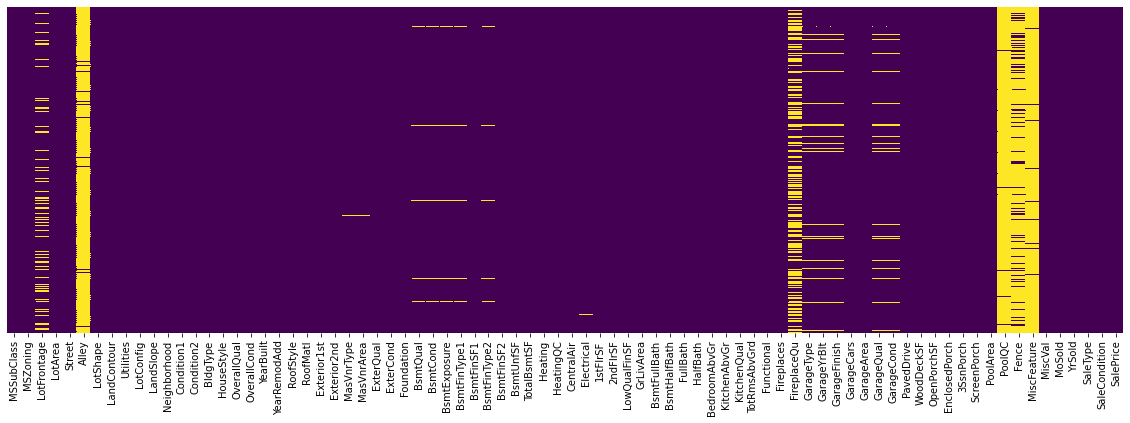

In [19]:
plt.figure(figsize=(20, 6))
sns.heatmap(train_data.isnull(),yticklabels=False,cbar=False,cmap='viridis');

### Checking what kind of values vary among features

In [20]:
quantitative = [f for f in train_data.columns if train_data.dtypes[f] != 'object']
quantitative.remove('SalePrice')
qualitative = [f for f in train_data.columns if train_data.dtypes[f] == 'object']

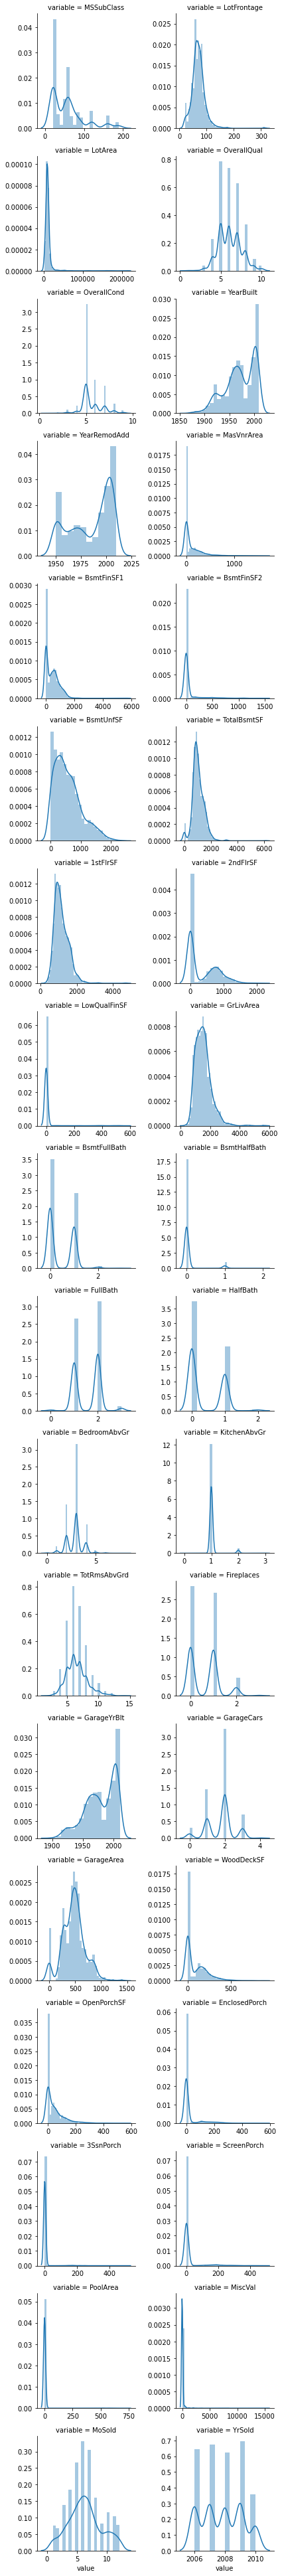

In [21]:
f = pd.melt(train_data, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

Numeric features are roughly normally distributed. We see that all of the features have some amount of skew. Additionally, we see that the range of values is all over. We can make the ranges more similar by using a scaler to remove the mean and scaling to unit variance.

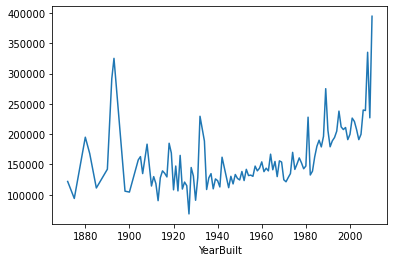

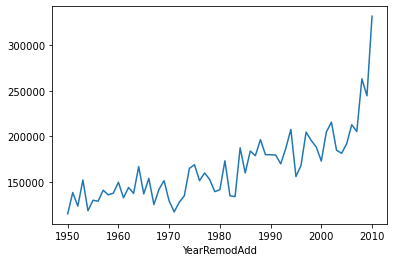

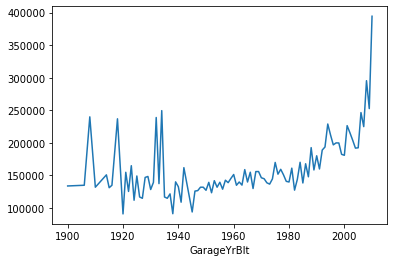

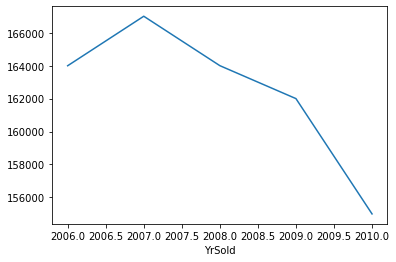

In [22]:
for feature in year_feature:
    data=train_data
    data.groupby(feature)['SalePrice'].median().plot()
    plt.show()

Newly built or remodelled houses and newly built garage has more median Sale Price. And overtime the median Sale Price has decreased for houses sold in recent years.

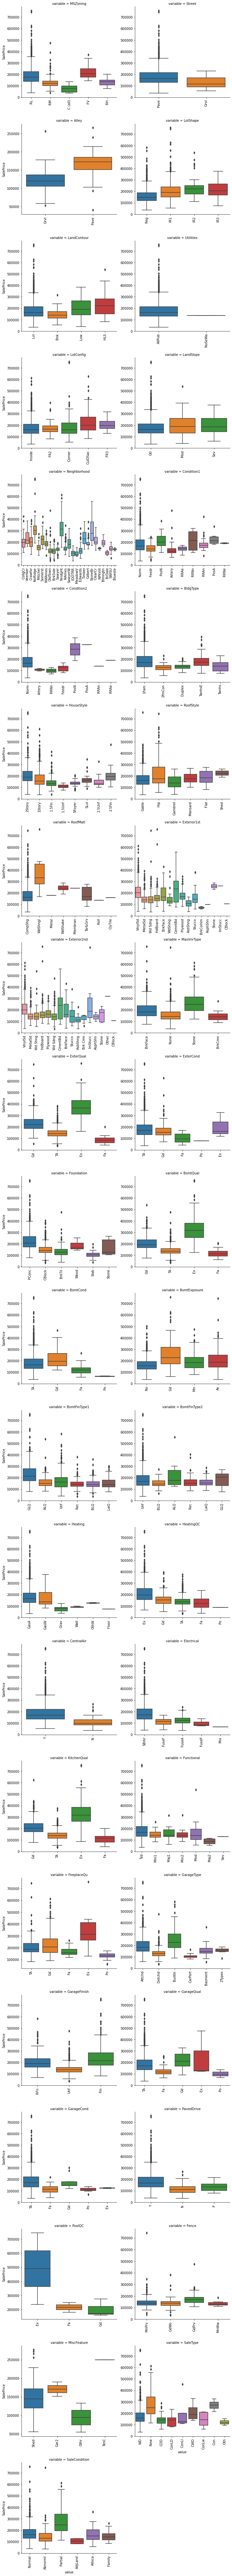

In [23]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train_data, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

Most categorical features have fewer than 10 unique values.
A few categorical features have greater than 15 unique values.
In general we should be fine with One Hot Encoding without overloading matrix dimensions.

### Target analysis

Skewness: 1.882876
Kurtosis: 6.536282


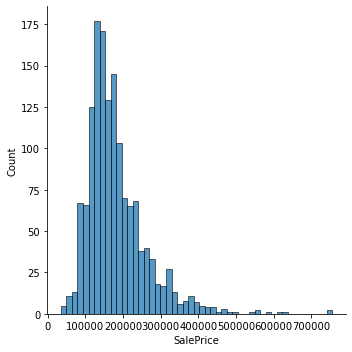

In [24]:
sns.displot(train_data["SalePrice"])
print("Skewness: %f" % train_data["SalePrice"].skew())
print("Kurtosis: %f" % train_data["SalePrice"].kurt())

Right Skewness. Will need log transform the target.

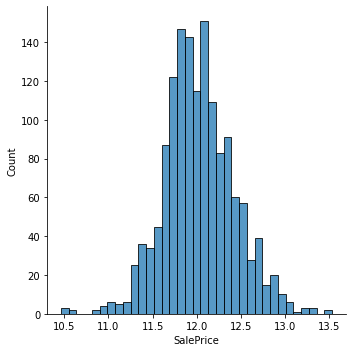

In [25]:
sale_price = np.log1p(train_data["SalePrice"])
sns.displot(sale_price);

### Correlation of features based on saleprice/target

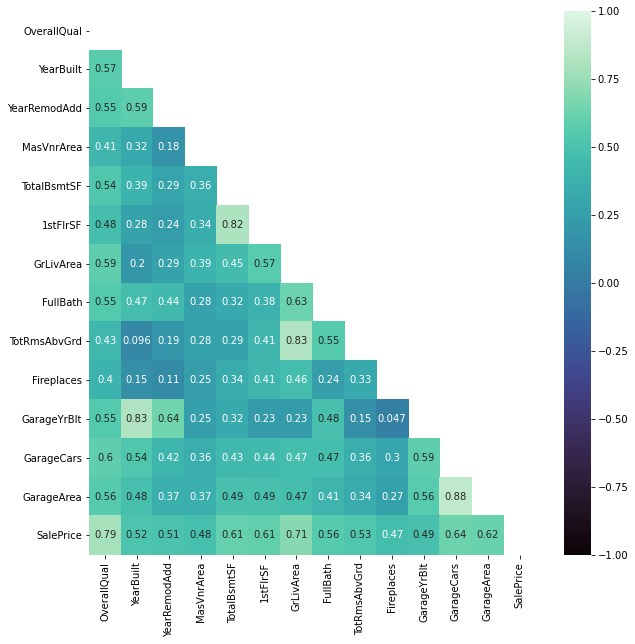

In [26]:
corrmat = train_data.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.4]
plt.figure(figsize=(10,10))
matrix = np.triu(top_corr_features)
sns.heatmap(train_data[top_corr_features].corr(),annot=True,cmap="mako", vmin = -1, vmax = 1, center = 0, mask = matrix);

GarageCars and GarageArea, TotalBsmtSf and lstFlrSF, GrLiveArea and TotRmsAbvGrd are very colerrated with each other.
OverallQual and GrLivArea has the strongest linear relationship with SalePrice. 
Hence, these 2 features will be important factor in predicting House Price.

Visualizing low vs high correlating features:

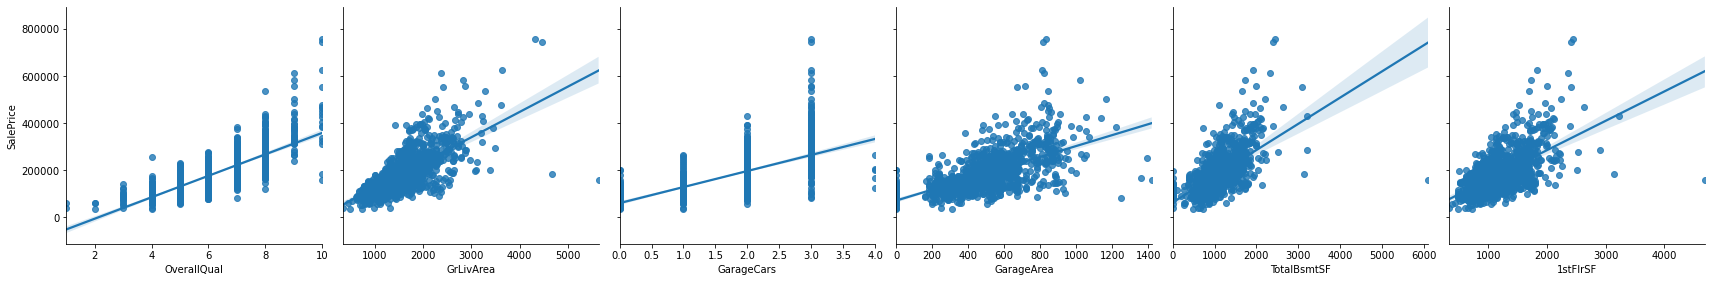

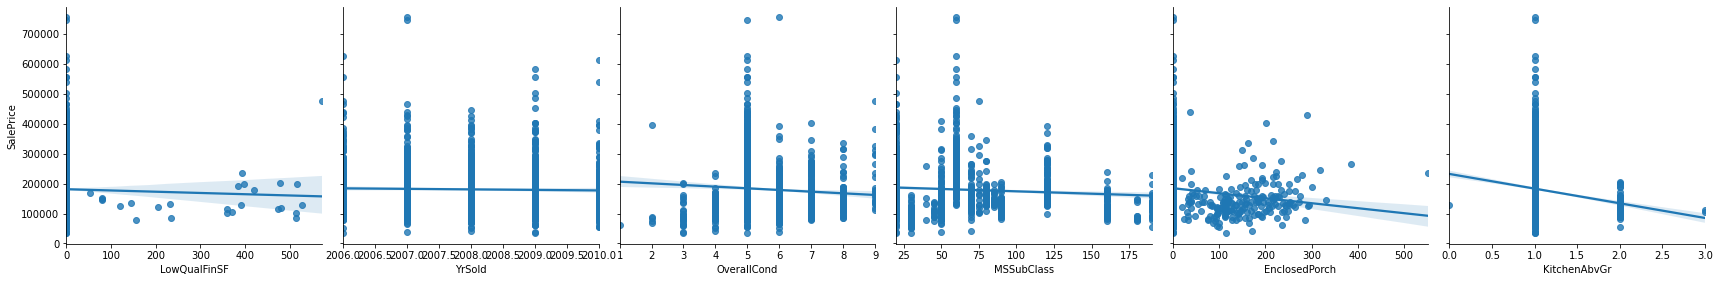

In [27]:
high_cor_feature = sns.PairGrid(train_data, y_vars=["SalePrice"], x_vars=["OverallQual","GrLivArea","GarageCars","GarageArea","TotalBsmtSF","1stFlrSF"], height=4)
high_cor_feature.map(sns.regplot)

low_cor_feature = sns.PairGrid(train_data, y_vars=["SalePrice"], x_vars=["LowQualFinSF","YrSold","OverallCond","MSSubClass","EnclosedPorch","KitchenAbvGr"], height=4)
low_cor_feature.map(sns.regplot)

* High correlation features draw a possitive regression line with saleprice/target.
* Low correlation features draw a negative regression line with saleprice/target.

### Ckecking for outliers for most effective features

SalePrice vs GrLivArea

<AxesSubplot:xlabel='GrLivArea'>

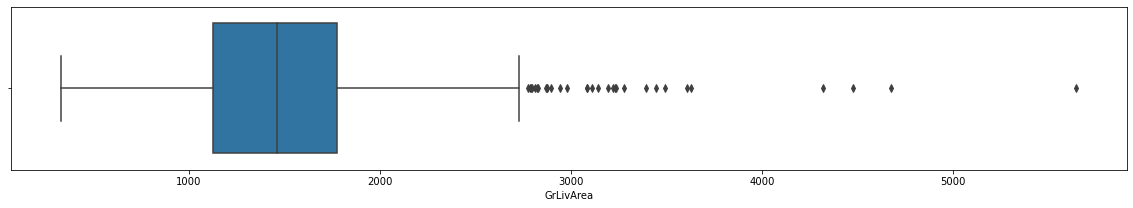

In [28]:
plt.figure(figsize = (20, 3))
sns.boxplot(x = train_data['GrLivArea'])

There are two distinct outliers that have huge square footage but cheap prices

In [29]:
outliers = train_data.loc[(train_data.SalePrice < 200000) & (train_data.GrLivArea > 4000)]
#train_data.drop(outliers.index, inplace=True)

### Feature engineering:

Creating new features for the data:

In [6]:
train_data['OverallQualCond'] = train_data['OverallQual'] * train_data['OverallCond']
train_data['TotalSF'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']
train_data['Interaction'] = train_data['TotalSF'] * train_data['OverallQual']
train_data['has2ndfloor'] = train_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train_data['hasbsmt'] = train_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train_data['YearBuilt'] = train_data['YrSold'] - train_data['YearBuilt']
train_data['YearRemodAdd'] = train_data['YrSold'] - train_data['YearRemodAdd']
test_data['OverallQualCond'] = test_data['OverallQual'] * test_data['OverallCond']
test_data['TotalSF'] = test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF']
test_data['Interaction'] = test_data['TotalSF'] * test_data['OverallQual']
test_data['has2ndfloor'] = test_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test_data['hasbsmt'] = test_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
test_data['YearBuilt'] = test_data['YrSold'] - test_data['YearBuilt']
test_data['YearRemodAdd'] = test_data['YrSold'] - test_data['YearRemodAdd']

## Preprocessing

In [8]:
X = train_data.drop('SalePrice', axis=1)
y = train_data.SalePrice
RANDOM_STATE = 1

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, 
                                                random_state=RANDOM_STATE)

### Pipelines

* Replace missing values in numeric features with the median.
* Replace missing values in categorical features with None.
* OneHot Encode categorical features.
* Scale numeric features.

In [10]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

In [11]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', RobustScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value='None')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

_ = full_processor.fit_transform(X_train)

#### Baseline model:

Checking the error before any modeling is performed:

In [12]:
train_mean = np.mean(y_train)
print(train_mean)

182208.34160958903


In [13]:
baseline_prediction = np.ones(y_valid.shape) * train_mean

RMSE:

In [14]:
mean_squared_error(np.log(y_valid), np.log(baseline_prediction), squared=False)

0.4356060054199308

Without any machine learning techniques/modeling, the RMSE is 0.43 off from the actual price. Thus, the target is to build a model with smaller RMSE as possible.

### Xgboost model

Baseline model:

In [15]:
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=2,
                       min_child_weight=1,
                       base_score=1,
                       random_state=RANDOM_STATE)

In [16]:
%%time

xgboost_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', xgboost)
])
xgboost_pipeline.fit(X_train, y_train)

Wall time: 22.6 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFin...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.01,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=6000, n_jobs=8, num_parallel_tree=1,
                              random_state=1, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [17]:
preds = xgboost_pipeline.predict(X_valid)

Scores:

In [94]:
print(mean_squared_error(np.log(y_valid), np.log(preds), squared=False))

0.12574480629629706


In [95]:
print("Train Score:",xgboost_pipeline.score(X_train, y_train))
print("Test Score:",xgboost_pipeline.score(X_valid, y_valid))

Train Score: 0.9812016863144546
Test Score: 0.9357133071503734


Hyperparameter tuning:

In [83]:
xgboost_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocess', 'model', 'preprocess__n_jobs', 'preprocess__remainder', 'preprocess__sparse_threshold', 'preprocess__transformer_weights', 'preprocess__transformers', 'preprocess__verbose', 'preprocess__number', 'preprocess__category', 'preprocess__number__memory', 'preprocess__number__steps', 'preprocess__number__verbose', 'preprocess__number__impute', 'preprocess__number__scale', 'preprocess__number__impute__add_indicator', 'preprocess__number__impute__copy', 'preprocess__number__impute__fill_value', 'preprocess__number__impute__missing_values', 'preprocess__number__impute__strategy', 'preprocess__number__impute__verbose', 'preprocess__number__scale__copy', 'preprocess__number__scale__quantile_range', 'preprocess__number__scale__with_centering', 'preprocess__number__scale__with_scaling', 'preprocess__category__memory', 'preprocess__category__steps', 'preprocess__category__verbose', 'preprocess__category__impute', 'preprocess__category__one-hot',

In [96]:
distributions = dict(
    model__learning_rate=[0.20, 0.5, 1, 2],
    model__n_estimators = [5000, 5500, 6000, 6500],
    model__max_depth = [2, 3, 4, 5, 6],
    model__min_child_weight=[0, 0.5, 1, 1.5],
    model__base_score=[2, 2.5, 3]
)

In [98]:
%%time

random_cv = RandomizedSearchCV(xgboost_pipeline,
            distributions,
            cv=4, n_iter=5,
            n_jobs = 8,
            verbose = 5, 
            return_train_score = True,
            random_state=RANDOM_STATE).fit(X_train,y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   40.2s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:  1.7min remaining:  1.7min
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:  4.6min remaining:  1.5min
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:  4.9min finished


Wall time: 5min 22s


Getting the specific hyper parameter value from the best combination as follows:

In [100]:
random_cv.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFin...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.2,
                              max_delta_step=0, max_depth=4,
                              min_child_weight=0.5, missing=nan,
                              monotone_constraints='()', n_estimators=5500,
                              n_jobs=8, num_parallel_tree=1, random_state=1,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [18]:
regressor = XGBRegressor(learning_rate=0.2,
                       n_estimators=5500,
                       max_depth=4,
                       min_child_weight=0.5,
                       base_score=2,
                       random_state=RANDOM_STATE)

In [19]:
%%time

final_xgboost_pipe = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', regressor)
])
final_xgboost_pipe.fit(X_train, y_train)

Wall time: 31.2 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFin...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.2,
                              max_delta_step=0, max_depth=4,
                              min_child_weight=0.5, missing=nan,
                              monotone_constraints='()', n_estimators=5500,
                              n_jobs=8, num_parallel_tree=1, random_state=1,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [20]:
preds = final_xgboost_pipe.predict(X_valid)

Scores:

In [21]:
print(mean_squared_error(np.log(y_valid), np.log(preds), squared=False))

0.13148463814402955


In [105]:
print("Train Score:",final_xgboost_pipe.score(X_train, y_train))
print("Test Score:",final_xgboost_pipe.score(X_valid, y_valid))

Train Score: 0.9999999999959397
Test Score: 0.8937769591533289


Predicting on test data:

In [112]:
preds = final_xgboost_pipe.predict(test_data)

In [113]:
output = pd.DataFrame({'Id': test_ID,
                       'SalePrice': preds})
output.to_csv('xgb_tuned.csv', index=False)
output.head()

,Id,SalePrice
0,1461,123942.992188
1,1462,173714.187500
2,1463,188905.593750
3,1464,188230.171875
4,1465,171451.390625


## Pipeline having neural network regressor

Baseline model:

In [22]:
nnet = MLPRegressor(
    hidden_layer_sizes=(200,200,200),
    alpha=0,
    max_iter=200,
    random_state=RANDOM_STATE
)
nnet

MLPRegressor(alpha=0, hidden_layer_sizes=(200, 200, 200), random_state=1)

In [23]:
%%time

nnet_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', nnet)
])
nnet_pipeline.fit(X_train, y_train)

Wall time: 17.6 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFin...
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])])),
                ('model',
                 MLPRegressor(alpha=0, hidden_layer_sizes=(200, 200, 200),
                              random_state=1))])

In [24]:
preds = nnet_pipeline.predict(X_valid)

Scores:

In [117]:
print(mean_squared_error(np.log(y_valid), np.log(preds), squared=False))

0.16741466730026475


In [118]:
print("Train Score:",nnet_pipeline.score(X_train, y_train))
print("Test Score:",nnet_pipeline.score(X_valid, y_valid))

Train Score: 0.9075798965187583
Test Score: 0.8033676724311342


Hyperparameter tuning:

In [41]:
nnet_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocess', 'model', 'preprocess__n_jobs', 'preprocess__remainder', 'preprocess__sparse_threshold', 'preprocess__transformer_weights', 'preprocess__transformers', 'preprocess__verbose', 'preprocess__number', 'preprocess__category', 'preprocess__number__memory', 'preprocess__number__steps', 'preprocess__number__verbose', 'preprocess__number__impute', 'preprocess__number__scale', 'preprocess__number__impute__add_indicator', 'preprocess__number__impute__copy', 'preprocess__number__impute__fill_value', 'preprocess__number__impute__missing_values', 'preprocess__number__impute__strategy', 'preprocess__number__impute__verbose', 'preprocess__number__scale__copy', 'preprocess__number__scale__quantile_range', 'preprocess__number__scale__with_centering', 'preprocess__number__scale__with_scaling', 'preprocess__category__memory', 'preprocess__category__steps', 'preprocess__category__verbose', 'preprocess__category__impute', 'preprocess__category__one-hot',

In [159]:
distributions = dict(
    model__alpha=[0.01, 0.1, 0, 1],
    model__hidden_layer_sizes=[300,400,500],
    model__max_iter=[500, 600, 700]
)

In [160]:
%%time

pipe_rs = RandomizedSearchCV(
    nnet_pipeline,
    distributions,
    cv=4, n_iter=3,
    n_jobs = 8,
    verbose = 5, 
    return_train_score = True,
    random_state=RANDOM_STATE).fit(X_train,y_train)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:  2.1min remaining:  6.4min
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:  3.8min remaining:  3.8min
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:  3.9min remaining:  1.3min
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:  3.9min finished


Wall time: 4min 45s


Getting the specific hyper parameter value from the best combination as follows:

In [161]:
pipe_rs.best_params_

{'model__max_iter': 600, 'model__hidden_layer_sizes': 500, 'model__alpha': 1}

Using newly found parameter values to train a neural network model:

In [25]:
nnet = MLPRegressor(
    hidden_layer_sizes=(500,500,500), 
    max_iter=600,
    alpha=1,
    random_state=RANDOM_STATE
)

In [26]:
%%time

final_nnet_pipe = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', nnet)
])
final_nnet_pipe.fit(X_train, y_train)

Wall time: 58.8 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFin...
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])])),
                ('model',
                 MLPRegressor(alpha=1, hidden_layer_sizes=(500, 500, 500),
                              max_iter=600, random_state=1))])

Scores:

In [27]:
preds = final_nnet_pipe.predict(X_valid)

In [72]:
print(mean_squared_error(np.log(y_valid), np.log(preds), squared=False))

0.16336502166142086


In [73]:
print("Train Score:",final_nnet_pipe.score(X_train, y_train))
print("Test Score:",final_nnet_pipe.score(X_valid, y_valid))

Train Score: 0.8940620395010361
Test Score: 0.8074804573819496


Predicting target variables on the test data:

In [121]:
preds = final_nnet_pipe.predict(test_data)

In [122]:
output = pd.DataFrame({'Id': test_ID,
                       'SalePrice': preds})
output.to_csv('nnet_tuned.csv', index=False)
output.head()

,Id,SalePrice
0,1461,115230.947516
1,1462,342096.921907
2,1463,186990.033714
3,1464,203384.094173
4,1465,197876.714276


## Pipeline having gradient boosted regressor

Baseline model:

In [28]:
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                min_samples_leaf=15,
                                min_samples_split=10,
                                random_state=RANDOM_STATE)

In [29]:
%%time

gbr_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', gbr)
])
gbr_pipeline.fit(X_train, y_train)

Wall time: 1min 25s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFin...
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=4,
                                           min_samples_leaf=15,
                                           min_samples_split=10,
                                           n_estimators=6000,
                                           random_state=1))])

In [30]:
preds = gbr_pipeline.predict(X_valid)

Score: 

In [133]:
print(mean_squared_error(np.log(y_valid), np.log(preds), squared=False))

0.13174483167808201


In [127]:
print("Train Score:",gbr_pipeline.score(X_train, y_train))
print("Test Score:",gbr_pipeline.score(X_valid, y_valid))

Train Score: 0.9976424794686977
Test Score: 0.9141036041686355


Hyperparameter tuning:

In [128]:
gbr_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocess', 'model', 'preprocess__n_jobs', 'preprocess__remainder', 'preprocess__sparse_threshold', 'preprocess__transformer_weights', 'preprocess__transformers', 'preprocess__verbose', 'preprocess__number', 'preprocess__category', 'preprocess__number__memory', 'preprocess__number__steps', 'preprocess__number__verbose', 'preprocess__number__impute', 'preprocess__number__scale', 'preprocess__number__impute__add_indicator', 'preprocess__number__impute__copy', 'preprocess__number__impute__fill_value', 'preprocess__number__impute__missing_values', 'preprocess__number__impute__strategy', 'preprocess__number__impute__verbose', 'preprocess__number__scale__copy', 'preprocess__number__scale__quantile_range', 'preprocess__number__scale__with_centering', 'preprocess__number__scale__with_scaling', 'preprocess__category__memory', 'preprocess__category__steps', 'preprocess__category__verbose', 'preprocess__category__impute', 'preprocess__category__one-hot',

In [31]:
distributions = dict(
    model__n_estimators=[100, 200, 300],
    model__learning_rate=[.025, .1],
    model__max_depth=[1,2,3],
    model__subsample=[1,2 ,3],
    model__min_samples_leaf=[10,15,20],
    model__min_samples_split=[15, 20, 25]
)

In [163]:
%%time

pipe_rs = RandomizedSearchCV(
    gbr_pipeline,
    distributions,
    cv=4, n_iter=6,
    n_jobs = 8,
    verbose = 5, 
    return_train_score = True,
    random_state=RANDOM_STATE).fit(X_train,y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    2.0s remaining:    1.4s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    2.0s remaining:    0.5s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    2.7s finished


Wall time: 4.52 s


In [164]:
pipe_rs.best_params_

{'model__subsample': 1,
 'model__n_estimators': 200,
 'model__min_samples_split': 20,
 'model__min_samples_leaf': 15,
 'model__max_depth': 3,
 'model__learning_rate': 0.025}

Using newly found parameter values to train a model:

In [32]:
gbr = GradientBoostingRegressor(n_estimators=200,
                                learning_rate=0.025,
                                subsample=1,
                                max_depth=3,
                                min_samples_leaf=15,
                                min_samples_split=20,
                                random_state=RANDOM_STATE)

In [33]:
%%time

final_gbr_pipe = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', gbr)
])
final_gbr_pipe.fit(X_train, y_train)

Wall time: 2.15 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFin...
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.025,
                                           min_samples_leaf=15,
                                           min_samples_split=20,
                                           n_estimators=200, random_state=1,
                                           subsample=1))])

In [34]:
preds = final_gbr_pipe.predict(X_valid)

Scores:

In [154]:
print(mean_squared_error(np.log(y_valid), np.log(preds), squared=False))

0.14257151929806328


In [155]:
print("Train Score:",final_gbr_pipe.score(X_train, y_train))
print("Test Score:",final_gbr_pipe.score(X_valid, y_valid))

Train Score: 0.9245774676380255
Test Score: 0.8966669628856782


Predicting target variables on the test data:

In [156]:
preds = final_gbr_pipe.predict(test_data)

In [157]:
output = pd.DataFrame({'Id': test_ID,
                       'SalePrice': preds})
output.to_csv('gbr_tuned.csv', index=False)
output.head()

,Id,SalePrice
0,1461,121558.364327
1,1462,170369.523540
2,1463,168774.715975
3,1464,183302.718088
4,1465,189733.247646


Models before tuning:

In [39]:
models = []
models.append(("XB",xgboost_pipeline))
models.append(("NN",nnet_pipeline))
models.append(("GB",gbr_pipeline))

for name,model in models:
   kfold = KFold(n_splits=5, random_state=RANDOM_STATE).get_n_splits(X_train.values)
   cv_result = np.sqrt(-cross_val_score(model,X,y, scoring="neg_mean_squared_error", cv = kfold))
   print(name, np.mean(cv_result))

XB 26975.874432726734
NN 30872.996569500036
GB 27046.265461265994


Models after tuning:

In [ ]:
models = []
models.append(("XB", final_xgboost_pipe))
models.append(("NN", final_nnet_pipe))
models.append(("GB", final_gbr_pipe))

for name,model in models:
   kfold = KFold(n_splits=5, random_state=RANDOM_STATE).get_n_splits(X_train.values)
   cv_result = np.sqrt(-cross_val_score(model,X,y, scoring="neg_mean_squared_error", cv = kfold))
   print(name, np.mean(cv_result))

XB 27493.241914400736


Conclusion:
* On validation data best performing model was xgboost. On test data: gradient boosted regressor.
* After tuning scores on validation data increased for neural network regressor, on test data: for xgboost.